# Loading the dataset

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_path = 'kaggle_housing_data/train.csv'
test_path = 'kaggle_housing_data/test.csv'

df_test = pd.read_csv(test_path)
df_train = pd.read_csv(train_path)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Remove majority null or majority single value features

In [95]:
from src import utils
try:
    df_train.drop("Id", axis=1, inplace=True)
    df_test.drop("Id", axis=1, inplace=True)
except:
    print("Id columns already removed.")

utils.drop_null_majority_features(df_train, df_test)
utils.drop_single_val_majority(df_train, df_test)
print(f"after:\n {df_train.describe()}")


after:
         MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726   567.240411  ...   
std      30.202904     20.645407   181.066207   456.098091   441.86

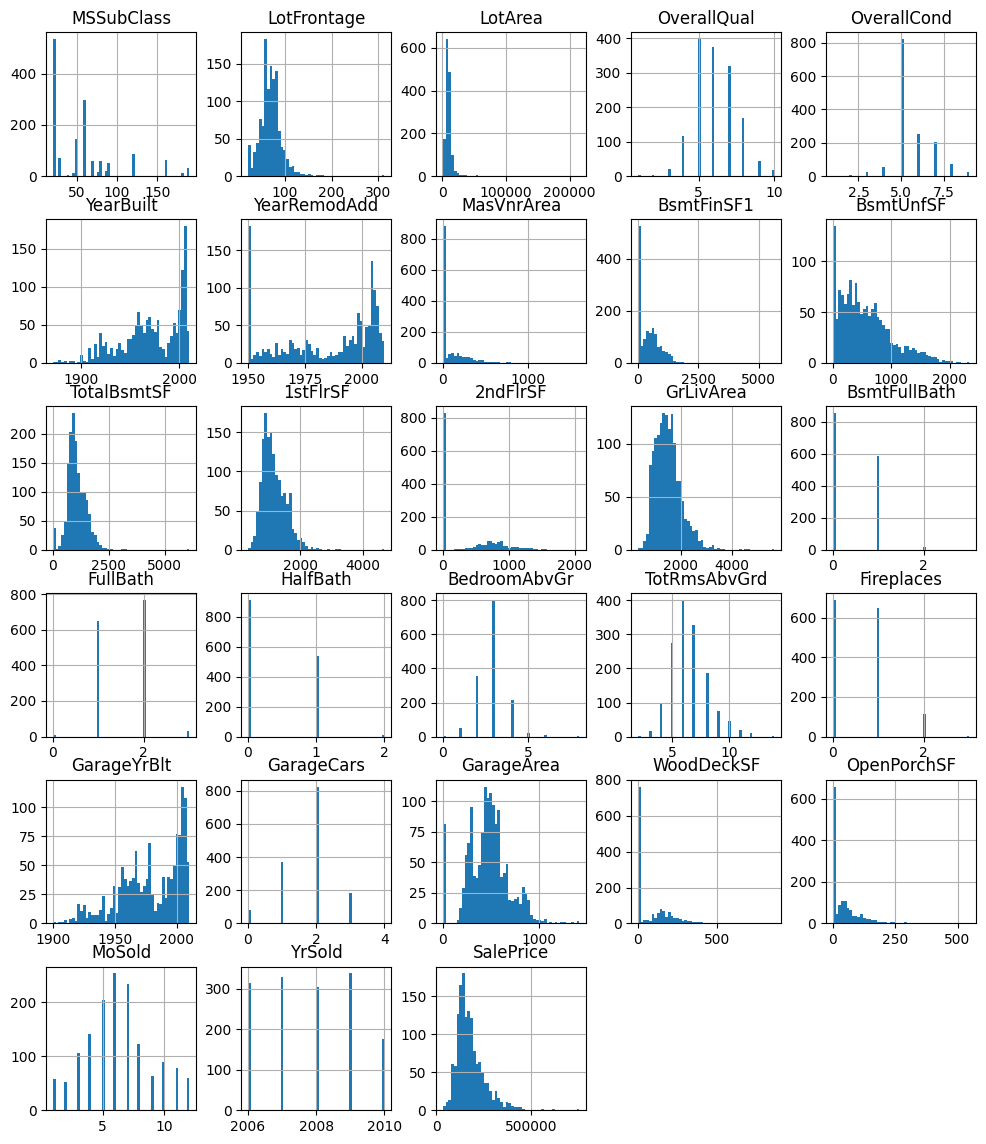

In [96]:

df_train.hist(bins=50, figsize=(12, 14))
plt.show()

In [100]:
corr_matrix = df_train.corr(numeric_only=True)
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
MoSold          0.046432
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
Name: SalePrice, dtype: float64


# Stratified split of the data based on overall quality of the house

In [108]:
strat_train_set, strat_test_set = train_test_split(
    df_train, test_size=0.2, stratify=df_train["OverallQual"],
    random_state=42
)

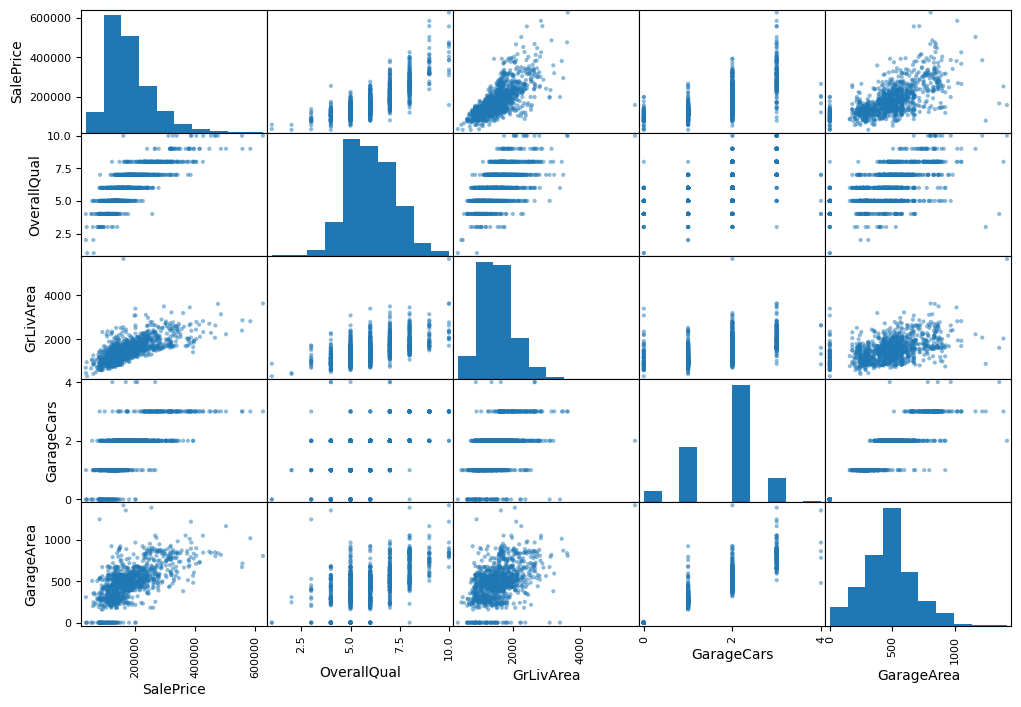

In [110]:
from pandas.plotting import scatter_matrix

attributes = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars",
              "GarageArea"]

scatter_matrix(strat_train_set[attributes], figsize=(12, 8))
plt.show()

Lets try to make some new useful features

In [111]:
housing = strat_train_set.copy()

In [ ]:
housing["1stFlrRatio"] = housing["1stFlrSF"] / housing["GrLivArea"]
housing[]

count      1168.000000
mean     180273.876712
std       75821.998322
min       34900.000000
25%      130000.000000
50%      163000.000000
75%      214600.000000
max      625000.000000
Name: SalePrice, dtype: float64